<a href="https://colab.research.google.com/github/wissamttajjar/ml_and_dm_project/blob/master/notebooks/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import re
tqdm.pandas()
from collections import defaultdict

#to prevent any data leakage we will split our data to test and train sghbs
split train to val and trainss              

In [3]:
def null_with_percentage(dataframe):
    null_counts = dataframe.isnull().sum()
    null_percentages = (dataframe.isnull().sum() / len(dataframe)) * 100
    null_analysis = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percentage': null_percentages,
        'Dtype': dataframe.dtypes  # Add dtypes information
    }).sort_values(by='Null Percentage', ascending=False)

    print("Null Value Counts, Percentages and Data Types per Column:")
    print(null_analysis)
    print("\n" + "="*70 + "\n")

In [4]:
import pickle# Later, load them back
with open('/content/drive/MyDrive/datasets/ml dm project datasets/X_train_fe.pkl', 'rb') as f:
    train = pickle.load(f)

with open('/content/drive/MyDrive/datasets/ml dm project datasets/X_val_fe.pkl', 'rb') as f:
    val = pickle.load(f)

with open('/content/drive/MyDrive/datasets/ml dm project datasets/test.pkl', 'rb') as f:
    test = pickle.load(f)

In [5]:
null_with_percentage(train)

Null Value Counts, Percentages and Data Types per Column:
                      Null Count  Null Percentage     Dtype
mileage_category            8422         3.212665  category
year                           0         0.000000   float64
manufacturer                   0         0.000000    object
model                          0         0.000000    object
condition                      0         0.000000  category
fuel                           0         0.000000    object
odometer                       0         0.000000   float64
title_status                   0         0.000000    object
price                          0         0.000000     int64
transmission                   0         0.000000    object
drive                          0         0.000000    object
type                           0         0.000000    object
size                           0         0.000000    object
state                          0         0.000000    object
lat                            0         0

In [6]:
rows_to_drop_train = train['mileage_category'].isnull()
rows_to_drop_val = val['mileage_category'].isnull()

# Drop the identified rows
train_cleaned = train.drop(train.index[rows_to_drop_train])
val_cleanedd = val.drop(val.index[rows_to_drop_val])

# Verify by checking null percentages again
print("\nNull percentages after dropping rows with null 'mileage_category' in train:")
null_with_percentage(train)

print("\nNull percentages after dropping rows with null 'mileage_category' in val:")
null_with_percentage(val_cleanedd)

# Replace the original variables with the cleaned versions
train = train_cleaned
val = val_cleanedd



Null percentages after dropping rows with null 'mileage_category' in train:
Null Value Counts, Percentages and Data Types per Column:
                      Null Count  Null Percentage     Dtype
mileage_category            8422         3.212665  category
year                           0         0.000000   float64
manufacturer                   0         0.000000    object
model                          0         0.000000    object
condition                      0         0.000000  category
fuel                           0         0.000000    object
odometer                       0         0.000000   float64
title_status                   0         0.000000    object
price                          0         0.000000     int64
transmission                   0         0.000000    object
drive                          0         0.000000    object
type                           0         0.000000    object
size                           0         0.000000    object
state                    

In [7]:
!pip install category_encoders
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 22.6 MB/s eta 0:00:00


In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

def evaluate(y_true, y_pred):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred)
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics

In [9]:
# === Split data ===
y_train = train['price']
y_val = val['price']
train = train.drop('price', axis=1)
val = val.drop('price', axis=1)

y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [12]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
import optuna



# === Define column groups ===
high_cardinality_cats = ['manufacturer']
low_cardinality_cats = ['fuel', 'title_status', 'transmission', 'drive', 'size']
numerical_cols = ['year', 'cylinders_numeric', 'log_odometer', 'car_age', 'fuel_efficiency']
binary_cols = [
    'is_electric', 'is_car_new', 'is_popular_state',
    'is_truck_or_suv', 'has_many_cylinders', 'is_common_color', 'is_rare_color',
    'is_northeast', 'is_west_coast', 'is_south', 'is_urban_area', 'is_automatic',
    'is_clean_title', 'is_domestic', 'is_popular_model'
]



# === Pipelines ===
num_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

low_cat_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

high_cat_pipe = Pipeline([
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical_cols),
    ('low_cat', low_cat_pipe, low_cardinality_cats),
    ('high_cat', high_cat_pipe, high_cardinality_cats)
], remainder='passthrough')

# === Model Pipeline ===
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor (
        random_state=42,
        verbose=1,         # shows progress of tree building
        n_jobs=-1
    ))
])

print("Remaining columns after transformation:")
cols_to_drop = (set(train.columns) - set(numerical_cols) - set(low_cardinality_cats) - set(high_cardinality_cats) - set(binary_cols))

train_copy = train.copy()
print(cols_to_drop)
train_copy.drop(columns=cols_to_drop, inplace=True)
print(train_copy.columns)

Remaining columns after transformation:
{'condition_score', 'is_recent_model', 'cylinders_confidence', 'type', 'odometer', 'condition', 'mileage_category', 'state', 'long', 'model', 'odometer_imputed', 'lat', 'odometer_outlier', 'paint_color'}
Index(['year', 'manufacturer', 'fuel', 'title_status', 'transmission', 'drive',
       'size', 'cylinders_numeric', 'log_odometer', 'is_electric', 'car_age',
       'is_car_new', 'is_popular_state', 'is_truck_or_suv',
       'has_many_cylinders', 'is_common_color', 'is_rare_color',
       'is_northeast', 'is_west_coast', 'is_south', 'is_urban_area',
       'is_automatic', 'is_clean_title', 'is_domestic', 'is_popular_model',
       'fuel_efficiency'],
      dtype='object')


In [ ]:
def objective(trial):
    # --- Sample hyperparameters ---
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # --- Define model ---
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        n_jobs=-1,
        random_state=42
    )

    # --- Define pipeline with this RF ---
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', rf)
    ])

    # --- Cross-validation ---
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, train_copy, y_train_log,
        scoring='neg_root_mean_squared_error',
        cv=kf,
        n_jobs=-1
    )

    return -1 * np.mean(scores)  # minimize RMSE

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("🔍 Best hyperparameters:")
print(study.best_params)

[I 2025-07-18 13:51:15,369] A new study created in memory with name: no-name-a9e00e94-4611-40db-b015-88fc99687894
[I 2025-07-18 13:51:55,235] Trial 0 finished with value: 2.6046411966932475 and parameters: {'n_estimators': 133, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 2.6046411966932475.
[I 2025-07-18 13:58:05,035] Trial 1 finished with value: 2.3216816653660355 and parameters: {'n_estimators': 125, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 2.3216816653660355.
[I 2025-07-18 14:00:08,437] Trial 2 finished with value: 2.472982443259547 and parameters: {'n_estimators': 256, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: 2.3216816653660355.
[I 2025-07-18 14:00:42,594] Trial 3 finished with value: 2.5979801106151474 and parameters: {'n_estimators': 143, 'max_depth': 6, 'min_s

🔍 Best hyperparameters:
{'n_estimators': 119, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': None}


In [ ]:
best_rf = RandomForestRegressor(**study.best_params, n_jobs=-1, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', best_rf)
])

pipeline.fit(train_copy, y_train_log)

# Predict and evaluate on original scale
y_pred_log = pipeline.predict(val)
y_pred = np.expm1(y_pred_log)

from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mse)
medae = median_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"📊 RMSE: {rmse:,.4f}")
print(f"MAE: {mae:,.4f}")
print(f"MedAE: {medae:,.4f}")
print(f"R²: {r2:.4f}")

📊 RMSE: 19,914.7904
MAE: 8,464.4598
MedAE: 4,404.9403
R²: 0.0951


In [13]:
# === Fit & Track Time ===
print("Training started...")
start = time.time()
pipeline.fit(train_copy, y_train_log)
end = time.time()
print(f"✅ Training completed in {(end - start):.2f} seconds.")

# === Predict & Evaluate ===
y_pred_log = pipeline.predict(val)
y_pred = np.expm1(y_pred_log)  # predicted prices in original scale

mse = mean_squared_error(y_val , y_pred)
rmse = np.sqrt(mse) # Take the square root to get RMSE
metrics = evaluate(y_val, y_pred)

Training started...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


✅ Training completed in 236.90 seconds.


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s


RMSE: 16487.3743
R²: 0.2370
MAE: 6272.5619
MedAE: 2265.6602


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.1s finished


In [ ]:
y_pred_original_scale = np.expm1(y_pred)
mse = mean_squared_error(y_val_log , y_pred_original_scale)
rmse = np.sqrt(mse) # Take the square root to get RMSE
metrics = evaluate(y_val, y_pred_original_scale)

/tmp/ipython-input-39-1029633806.py:1: RuntimeWarning: overflow encountered in expm1
  y_pred_original_scale = np.expm1(y_pred)


ValueError: Input contains infinity or a value too large for dtype('float64').

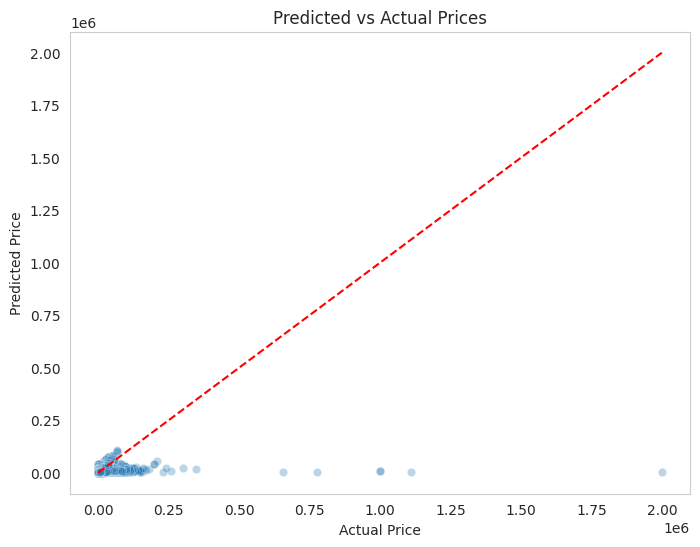

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred_original_scale, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.grid()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

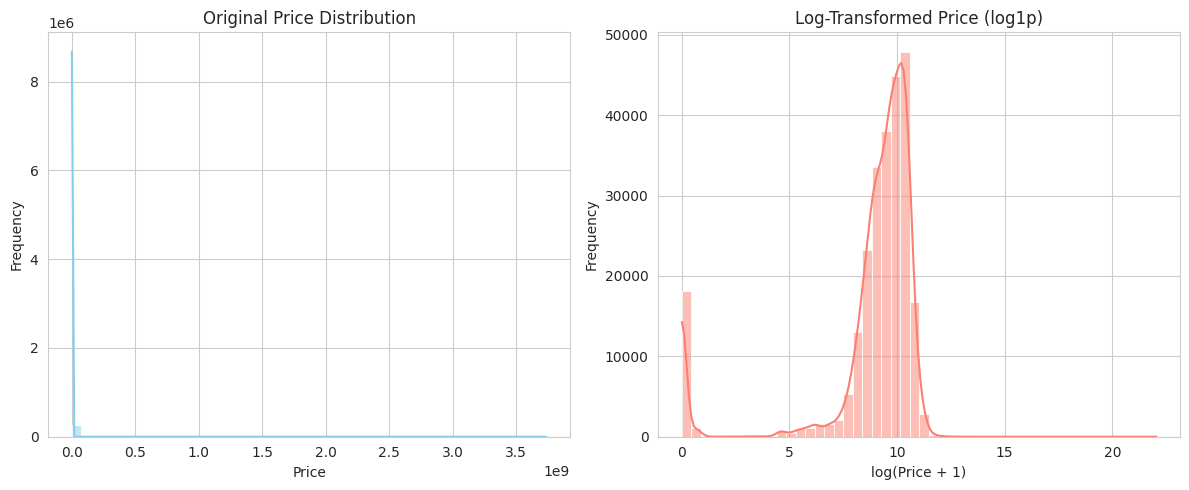

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original Price Distribution
sns.histplot(y_train, bins=50, kde=True, ax=ax1, color='skyblue')
ax1.set_title("Original Price Distribution")
ax1.set_xlabel("Price")
ax1.set_ylabel("Frequency")

# Log-Transformed Price Distribution
sns.histplot(np.log1p(y_train), bins=50, kde=True, ax=ax2, color='salmon')
ax2.set_title("Log-Transformed Price (log1p)")
ax2.set_xlabel("log(Price + 1)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

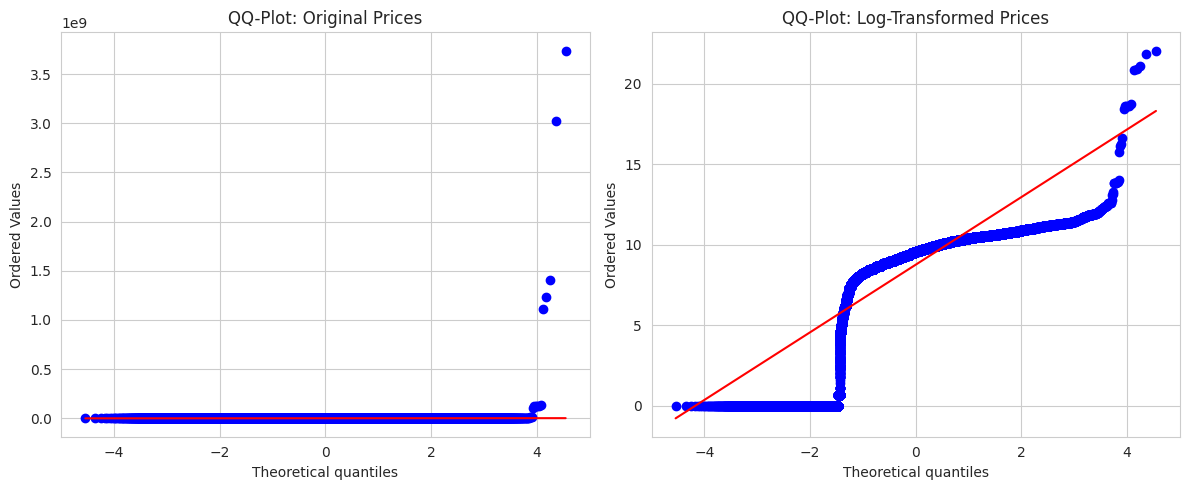

In [ ]:
from scipy import stats

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Original Prices
stats.probplot(y_train, dist="norm", plot=ax1)
ax1.set_title("QQ-Plot: Original Prices")

# Log-Prices
stats.probplot(np.log1p(y_train), dist="norm", plot=ax2)
ax2.set_title("QQ-Plot: Log-Transformed Prices")

plt.tight_layout()
plt.show()